# Link to this colab notebook.
https://drive.google.com/file/d/1x30tnpI20lVzQtJStAj0dG4y8oxWIBw-/view?usp=sharing

# Methods

This is a transformer model that embeds text and audio into the same space. It has encoder-decoder structure. The model encodes the input text and audio data and try to reconstruct the audio based on an additional embedding input information in the decoder half of the model.


Here is the procedures that we have followed:

1. Collect/clean the data
2. Store on Google Drive
3. Load all the files with their corresponding text
4. Process data for VoxCeleb
5. Create embeddings using VoxCeleb
6. Fine-tune pre-trained SpeechT5 on audio files with text
and speaker embeddings
7. Create audio samples and test for authenticity in respect
to the original voice


# Libraries

In [ ]:
# Install pydub, speechbrain, datasets
! pip install pydub speechbrain datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 46.6 MB/s eta 0:00:00


In [ ]:
! pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 30.8 MB/s eta 0:00:00


In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH = 'drive/MyDrive/College/USF/Deep_Learning_Mustafa/Project'
PATH_2 = PATH + '/sam_jackson_wav/iteration_2'

Mounted at /content/drive


In [ ]:
# Import libraries
import os
import pickle

import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from scipy import signal
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchaudio
import soundfile as sf
# import noisereduce as nr
from pydub import AudioSegment, effects

from speechbrain.pretrained import EncoderClassifier

from datasets import Dataset
from transformers import SpeechT5Processor, SpeechT5ForSpeechToSpeech, SpeechT5HifiGan
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
import accelerate

# Data Preprocessing

Our model was trained on Samuel Jackson's Sound Clips. Both audio and text transcription are involved. We gathered 158 pieces of Samuel Jackson's sound recording of various length. Then, these recordings were cast into wav file of 16000 Hz sampling rate and 1 channel. The sound files were represented by array of audio amplitudes for the model to use. The texts are transcribed by the team members. Texts are stored into dictionaries with keys being the sounds file name and values being the transcription text to allow convenient look up.

In [ ]:
def change_sample_rate(wav_file, sr=16000):
    # Import wav file
    audio = AudioSegment.from_file(wav_file)

    # Change to desired sample rate and channels
    audio = audio.set_frame_rate(sr)
    audio = audio.set_channels(1)
    audio = effects.normalize(audio)

    # Export new wav file
    audio.export(wav_file, format='wav')

In [ ]:
def clean_audio_numbered(m4a_file_path, wav_path):
    files = [x for x in os.walk(mda_file_path)][0][2:][0]
    paths = [mda_file_path + "/" + x for x in files]
    paths.remove(f"{mda_file_path}/.DS_Store")
    names = [x[:-4] + "_adam.wav" for x in files]
    names.remove(".DS_S_adam.wav")

    # Make dict which maps files to text index
    dict_text = dict()
    for x in names:
        dict_text[int(x[:-9])] = x

    # load transcripts in
    with open("sj_quotes.txt") as f:
        sj_quotes = f.read().split('\n')

    dict_sj_quotes = dict()

    # convert dict_text to {wav_file_name: quote}
    for i in range(len(sj_quotes)):
        dict_sj_quotes[dict_text[i+1]]= sj_quotes[i]

    # save to pickle
    with open("adam_dict.pkl", 'wb') as file:
        pickle.dump(dict_sj_quotes, file)

    # make wav directory
    old_dir = os.getcwd()
    if not os.path.exists(path):
        # Create the directory
        os.makedirs(wav_path)
        os.chdir(wav_path)
    else:
        os.chdir(wav_path)
    # export as wav
    for i in range(len(paths)):
        # read audio in
        song = AudioSegment.from_file(paths[i])

        # set frame rate and number of channels readed by model
        song = song.set_frame_rate(16000)
        song = song.set_channels(1)
        song = effects.normalize(audio)

        # export as wav
        song.export(names[i],format="wav")
        print(names[i])

    #change back to orginal dir
    os.chdir(old_dir)

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#PATH = 'drive/MyDrive/College/USF/Deep_Learning_Mustafa/Project'
sam_PATH = PATH + '/sam_jackson_wav/processed'
sam_PATH2 = PATH + '/sam_jackson_wav/iteration_3'
#our_PATH = PATH + '/our_speech'
dan_PATH = PATH_2 + '/Daniel'
yusong_PATH = PATH_2 + '/Yusong'
adam_PATH = PATH_2 + '/Adam'

In [ ]:
# Collect the sound files paths from the first 39 examples.
samfiles = []
for file in os.listdir(sam_PATH):
  if os.path.isfile(os.path.join(sam_PATH, file)):
    samfiles.append([sam_PATH + '/' + file,0])

In [ ]:
from drive.MyDrive.College.USF.Deep_Learning_Mustafa.Project.sam_jackson_wav.processed.sam_text.sam_text import sam2text

In [ ]:
# Collect the sound files paths from the iteration 2 and iteration 3 examples.
allfiles = []
for file_name in os.listdir(adam_PATH):
    if os.path.isfile(os.path.join(adam_PATH, file_name)):
        # Process the file
        allfiles.append([adam_PATH + '/' + file_name, 0])

for file_name in os.listdir(dan_PATH):
    if os.path.isfile(os.path.join(dan_PATH, file_name)):
        # Process the file
        allfiles.append([dan_PATH + '/' + file_name, 0])

for file_name in os.listdir(yusong_PATH):
    if os.path.isfile(os.path.join(yusong_PATH, file_name)):
        # Process the file
        allfiles.append([yusong_PATH + '/' + file_name, 0])

for file_name in os.listdir(sam_PATH2):
    if os.path.isfile(os.path.join(sam_PATH2, file_name)):
        # Process the file
        allfiles.append([sam_PATH2 + '/' + file_name, 0])


In [ ]:
# load all the wave file to text mapping dictionary
import pickle

with open(adam_PATH + '/text/iter2_dict.pkl', 'rb') as f:
  adam2text = pickle.load(f)

with open(yusong_PATH + '/text/transcription.pkl', 'rb') as f:
  yusong2text = pickle.load(f)

with open(dan_PATH + '/text/sam_dict2.pkl', 'rb') as f:
  dan2text = pickle.load(f)

with open(sam_PATH2 + '/text/sam_dict3.pkl', 'rb') as f:
  sam2_2text = pickle.load(f)

In [ ]:
# Combine all the wave file to texts mapping dictionaries
sam2text.update(adam2text)
sam2text.update(yusong2text)
sam2text.update(dan2text)
sam2text.update(sam2_2text)

In [ ]:
len(allfiles), len(samfiles)

(119, 39)

In [ ]:
print(len(samfiles)),len(allfiles)
samfiles += allfiles
print(len(samfiles))

39
158


In [ ]:
sam_data = [{'text': sam2text[os.path.basename(file[0])], 'audio': wav.read(file[0])[1], 'speaker_id': 0} for file in samfiles]
#our_data = [{'text': sam2text[os.path.basename(file[0])], 'audio': wav.read(file[0])[1], 'speaker_id': file[1]} for file in allfiles]



# df = pd.DataFrame(data)
# dataset = Dataset.from_pandas(df)

In [ ]:
type(our_data[0]["audio"])

numpy.ndarray

In [ ]:
#data = sam_data + our_data

In [ ]:
df = pd.DataFrame(sam_data)
dataset = Dataset.from_pandas(df)

In [ ]:
print(dataset)

Dataset({
    features: ['text', 'audio', 'speaker_id'],
    num_rows: 158
})


In [ ]:
# Save the dataset as pickle
with open(PATH + '/sam_dataset_iter3.pkl', 'wb') as f:
   pickle.dump(dataset, f)

In [ ]:
# loading in dataset，from the provided pickle file as dataset.
with open(PATH + '/sam_dataset_iter3.pkl', 'rb') as f:
  dataset = pickle.load(f)

In [ ]:
type(dataset["audio"][0])

list

In [ ]:
# load base model from HuggingFace
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [ ]:
# Clean up text with tokenizer
tokenizer = processor.tokenizer

def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', '4', '7'}

In [ ]:
# replace non-word characters into words and texts.
replacements = [
    (' ', ' '),
    ('4','four'),
    ('7','seven')
]
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["text"] = inputs["text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

In [ ]:
# replacements = [
#     ('\t', ' '),
#     (' ', ' '),
#     ('%', 'percent'),
#     ('0', 'zero'),
#     ('1', 'one'),
#     ('2', 'two'),
#     ('3', 'three'),
#     ('4', 'four'),
#     ('5','five'),
#     ('6','six'),
#     ('7','seven'),
#     ('8','eight'),
#     ('9','nine'),
#     ('<','less than'),
#     ('>','greater than'),
#     ('=','equals'),
#     ('_',' '),
#     ('\x80',' '),
#     ('\x99',' '),
#     ('à','a'),
#     ('’',""),
#     ('\\',''),
#     ("you\\'ve","you've")
# ]

# def cleanup_text(inputs):
#     for src, dst in replacements:
#         inputs["text"] = inputs["text"].replace(src, dst)
#     return inputs

# dataset = dataset.map(cleanup_text)

In [ ]:
# Make a dictionary for sanity check of the sound files distribution
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

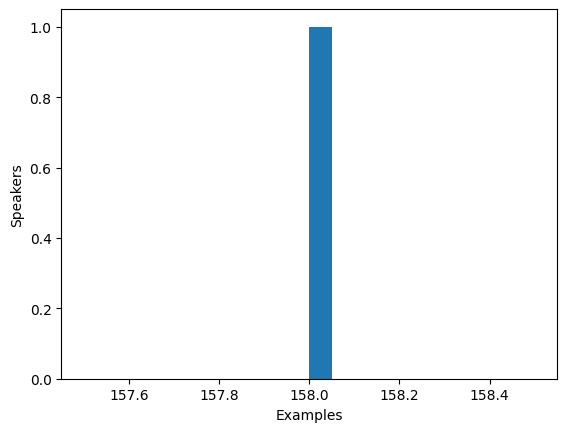

In [ ]:
# Plot the distribution
plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [ ]:
print("Speakers in the training dataset: ",len(set(dataset["speaker_id"])))
print("Number of Audiofiles in the dataset: ",len(dataset))

Speakers in the training dataset:  1
Number of Audiofiles in the dataset:  158


For each sound array, we created an embedding using the voxceleb model. Thus, the embedding is used as a target to converge the sounds profile.

In [ ]:
# Create speaker embedding using spk_model_name from speechbrain. Define the function that creates speaker embedding.

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [ ]:
# This function has the create speaker embedding function. This function will be used in dataset to be applied to each row to create its speaker embedding.
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # normalize audio
    array = np.array(audio)
    norm = np.linalg.norm(array)
    audio_norm = array / norm

    # feature extraction and tokenization
    example = processor(
        text=example["text"],
        audio_target=audio_norm,
        sampling_rate=16000,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio_norm)

    return example

In [ ]:
# Checking the processed example.
processed_example = prepare_dataset(dataset[0])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [ ]:
# Checking the processed example.
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
# Checking the processed example.
tokenizer.decode(processed_example["input_ids"])

"Shit negro that's all you had to say.</s>"

In [ ]:
# Checking the processed example.
processed_example["speaker_embeddings"].shape

(512,)

Below is a spectrogram of a processed sound file. Its horizontal axis represents time. Its vertical axis represents frequency. Its intensity represents amplitude.

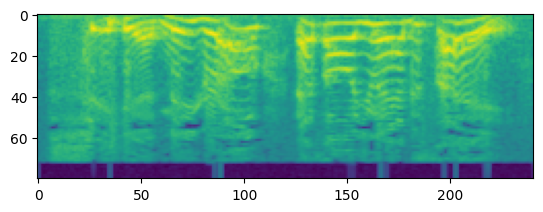

In [ ]:
# Checking the processed example.
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
# Download vocoder so that we can convert the spectrogram into audible sounds file.
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
# Convert the spectrogram into speech
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
# Convert the spectrogram into speech
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [ ]:
dataset.column_names

['text', 'audio', 'speaker_id']

In [ ]:
# Apply the prepare dataset function mentioned earlier to the whole dataset.
dataset_final = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/158 [00:00<?, ? examples/s]

In [ ]:
# Filter the lines that are too long.
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset_final = dataset_final.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/158 [00:00<?, ? examples/s]

In [ ]:
# Check the length of the dataset.
len(dataset_final)

158

In [ ]:
# Train test split.
dataset_split = dataset_final.train_test_split(test_size=0.1)

In [ ]:
# There are 142 training samples and 16 testing samples.
dataset_split

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 142
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 16
    })
})

In [ ]:
# Save the splitted dataset.
with open(PATH + '/sam_dataset_split_iter3.pkl', 'wb') as f:
   pickle.dump(dataset_split, f)

# Model Implementation

In [ ]:
# loading in dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
PATH = 'drive/MyDrive/College/USF/Deep_Learning_Mustafa/Project'
with open(PATH + '/sam_dataset_split_iter3.pkl', 'rb') as f:
  dataset_split = pickle.load(f)

Mounted at /content/drive


In [ ]:
# Create Padding to give the same length on all samples

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
# Combine Input and Target and Create Padding
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
# Sanity check for a batch created by three samples.
features = [
    dataset_split["train"][0],
    dataset_split["train"][1],
    dataset_split["train"][20],
]

batch = data_collator(features)

In [ ]:
# Sanity check for a batch created by three samples.
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 73]),
 'attention_mask': torch.Size([3, 73]),
 'labels': torch.Size([3, 238, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

In [ ]:
model.config.use_cache = False

## Hyperparameters
learning rate = 1e-5
epochs = 400

In [ ]:
# Define training parameters
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir= f"{PATH}/logs",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=25,
    max_steps=400,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=25,
    eval_steps=25,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [ ]:
# Create trainer object. Use the model and data to create the trainer.
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset_split["train"],
    eval_dataset=dataset_split["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

## Model Training

In [ ]:
# Model training.
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.169100,0.887768
50,0.962800,0.733065
75,0.879900,0.668853
100,0.825100,0.637679
125,0.740400,0.604342
150,0.677700,0.580739
175,0.665400,0.564774
200,0.674700,0.546634
225,0.647500,0.547437
250,0.615800,0.536354


TrainOutput(global_step=400, training_loss=0.71720876455307, metrics={'train_runtime': 281.7227, 'train_samples_per_second': 22.717, 'train_steps_per_second': 1.42, 'total_flos': 602205534640512.0, 'train_loss': 0.71720876455307, 'epoch': 44.44})

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
trainer.save_model(PATH + "/model")

Mounted at /content/drive


In [ ]:
# Save the trained model
torch.save(trainer.model_wrapped,f"{PATH}/model/sam_model_iter3.pt")

# Experiments and Results

In [ ]:
# Mount to google drive.
from transformers import AutoModel
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
model_path =  PATH + "/model/sam_model_iter3.pt"
model_loaded = torch.load(model_path)

Mounted at /content/drive


In [ ]:
dataset_split

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 142
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 16
    })
})

In [ ]:
# Select an embedding.
example = dataset_split["test"]["speaker_embeddings"][14]
speaker_embeddings = torch.tensor(example).unsqueeze(0).to(device)
speaker_embeddings.shape

torch.Size([1, 512])

In [ ]:
# Create the input. In this case, it is text.
device = "cuda" if torch.cuda.is_available() else "cpu"
text = "Happy birthday,     mother fucker"
inputs = processor(text=text, return_tensors="pt").to(device)

In [ ]:
# Generate prediction using the generate_speech method from the model. The model prediction is a spectrogram which can be converted into audible sound file with the vocoder later.
spectrogram = model_loaded.generate_speech(inputs["input_ids"], speaker_embeddings)

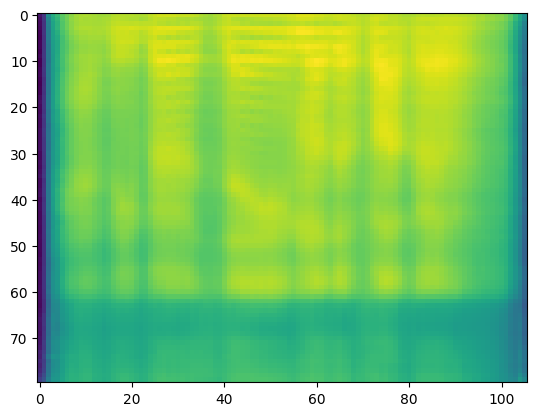

In [ ]:
# Show the spectrogram
plt.figure()
plt.imshow(spectrogram.cpu().T)
plt.show()

In [ ]:
# Generate audible sound file using vocoder and the spectrogram.
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
with torch.no_grad():
    speech = vocoder(spectrogram.cpu())

## Final Output
This output is somewhat robotic but it accomplishes our end goal

In [ ]:
# Load the sound file.
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
# Save the successfully generated audible sound file.
sf.write(f"{PATH}/happy_birthday.wav",15*speech.numpy(),samplerate=16000)

# Conclusion and Future Work

According to the experiments and observations, the model's generating performance depends on the specifc embedding that was used, and the quality of the input recording.

The original SpeechT5 model was trained on a dataset of
Audiobooks with monotone speakers and no background noise,
improving both the encoder and its understanding of
language. However, it struggles to capture rougher audio
with more tonal variance. We note that when trained on our
voices (monotone), we received much better results.

For the purpose of voice cloning, there are far
better/simpler models that exist. However, SpeechT5 does a
commendable job in multiple scenarios, such as speech to
text, text to speech, speech to speech, and more. As a
result, it generalizes to these fields but does not excel in
any of them.

Future work includes:
1. Obtain a larger data set for desired speakers
2. Clean the data more thoroughly and/or find higher quality
data
3. Better post-processing of the audio to remove choppiness
4. Larger training cycle to accommodate larger data set